In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from trainlib import lagndelay, scale, split
from scipy import stats


%matplotlib inline

In [2]:
#### 2. 데이터 불러오기 ####
data_df = pd.read_csv("../data/data/합천_댐기상종합_forTrain4_scaled_notflood.csv", index_col=0)
data_df.head()

,증기압(hPa),강수량(mm),1일후강수량,풍속(m/s),cos_week_of_year,저수량(현재),시정(10m),sin_month,최저운고(100m )
0,0.134666,0.000000,0.000000,0.191473,1.000000,0.582062,0.310185,0.5,0.114754
1,0.178363,0.000000,0.000000,0.240090,1.000000,0.580077,0.256145,0.5,0.114754
2,0.083422,0.000000,0.000000,0.150337,0.996354,0.576244,0.345077,0.5,0.114754
3,0.075344,0.000000,0.005805,0.114435,0.996354,0.573911,0.314015,0.5,0.114754
4,0.132150,0.005805,0.031605,0.105460,0.996354,0.570909,0.246784,0.5,0.125293


In [62]:
df2 = data_df.copy()
num_lags = 10 # number of lags and window lenghts for mean aggregation
delay = 3 # predict target five steps ahead
y = '당일유입량'
df_processed = lagndelay(num_lags, delay, df2, y)

/Users/jewel/Documents/2023_1학기/정미나_데이터사이언스캡스톤/code/2023-01-DSCapstone-InflowPrediction/code/models/trainlib.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_avg_window_length' + str(lag+1)] = df[column].shift(-1-(
/Users/jewel/Documents/2023_1학기/정미나_데이터사이언스캡스톤/code/2023-01-DSCapstone-InflowPrediction/code/models/trainlib.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_lag' + str(lag)] = df[column].shift(lag*-1-(delay-1))
/Users/jewel/Documents/2023_1학

In [63]:
df_train, df_test = split(0.8, df_processed)

In [64]:
h2o.init(ip="localhost", port=54323, nthreads=-1)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,1 hour 57 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_jewel_9nwifc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.503 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [65]:
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
X = hf_train.columns
X.remove(y)

In [66]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_6_20230529_151253_model_27,0.0343237,0.00117811,0.00954026,0.0275002,0.00117811
XGBoost_grid_1_AutoML_6_20230529_151253_model_6,0.0343954,0.00118304,0.0099425,0.0276408,0.00118304
GBM_grid_1_AutoML_6_20230529_151253_model_18,0.0345433,0.00119324,0.00955686,0.0279512,0.00119324
GBM_1_AutoML_6_20230529_151253,0.0345832,0.001196,0.00998053,0.0277015,0.001196
GBM_grid_1_AutoML_6_20230529_151253_model_50,0.0346167,0.00119832,0.00954524,0.0276522,0.00119832
GBM_grid_1_AutoML_6_20230529_151253_model_33,0.0346448,0.00120026,0.00872469,0.0275829,0.00120026
StackedEnsemble_BestOfFamily_4_AutoML_6_20230529_151253,0.0347038,0.00120435,0.0102404,0.028107,0.00120435
GBM_grid_1_AutoML_6_20230529_151253_model_43,0.034745,0.00120722,0.0100033,0.0277648,0.00120722
GBM_grid_1_AutoML_6_20230529_151253_model_19,0.0347658,0.00120866,0.00979203,0.0279412,0.00120866
GBM_grid_1_AutoML_6_20230529_151253_model_6,0.0347712,0.00120904,0.0103367,0.0278127,0.00120904


In [67]:
leader_model = aml.leader
hf_test_predict = leader_model.predict(hf_test)
df_results = pd.DataFrame()
df_results['ground_truth'] = df_test[y].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.head()

,ground_truth,predictions
0,0.001897,0.007113
1,0.000896,0.010143
2,0.001634,0.002138
3,0.000896,0.009232
4,0.000158,0.006325


In [68]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

y_test = df_results['ground_truth'].values
y_pred = df_results['predictions'].values
#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse, end="\t")
#MAE
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae, end="\t")
#MSE
mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
print("MSE:", mse, end="\t")

# PBIAS 계산
diff = np.sum(y_pred - y_test)
sum_observed = np.sum(y_test)
pbias = (diff / sum_observed) * 100
print('PBIAS:', pbias, end="\t")

# NSE 계산
diff_pred_obs = np.sum((y_pred - y_test) ** 2)
diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
nse = 1 - (diff_pred_obs / diff_obs_mean)
print('NSE:', nse, end="\t")
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
print('R2 = ',r_value*r_value)

RMSE: 0.0343236543686051	MAE: 0.009540260633840973	MSE: 0.0011781132492154638	PBIAS: 4.864129541412004	NSE: 0.2688249696504764	R2 =  0.27050617979095476


In [ ]:
6: RMSE: 0.03386182854444071	MAE: 0.010549754777035554	MSE: 0.0011466234323730998	PBIAS: 37.34445277138202	NSE: 0.2883685642927989
3: RMSE: 0.034062350729917125	MAE: 0.009883647498013499	MSE: 0.0011602437372478858	PBIAS: 21.3911208327713	NSE: 0.2799153643675597	
3-3 : RMSE: 0.03402165476116713	MAE: 0.009863598127652029	MSE: 0.0011574729926880458	PBIAS: 26.973428064118636	NSE: 0.28163497768909806	
4: RMSE: 0.03272931198411876	MAE: 0.008836422557423633	MSE: 0.0010712078629537803	PBIAS: 13.917138284236884	NSE: 0.335173895864885	
4-2: RMSE: 0.03467659119360274	MAE: 0.00827112767966728	MSE: 0.0012024659768082471	PBIAS: 0.13901761399412663	NSE: 0.25371088248729023	R2 =  0.256821436627479	
4-5: RMSE: 0.0343236543686051	MAE: 0.009540260633840973	MSE: 0.0011781132492154638	PBIAS: 4.864129541412004	NSE: 0.2688249696504764	R2 =  0.27050617979095476

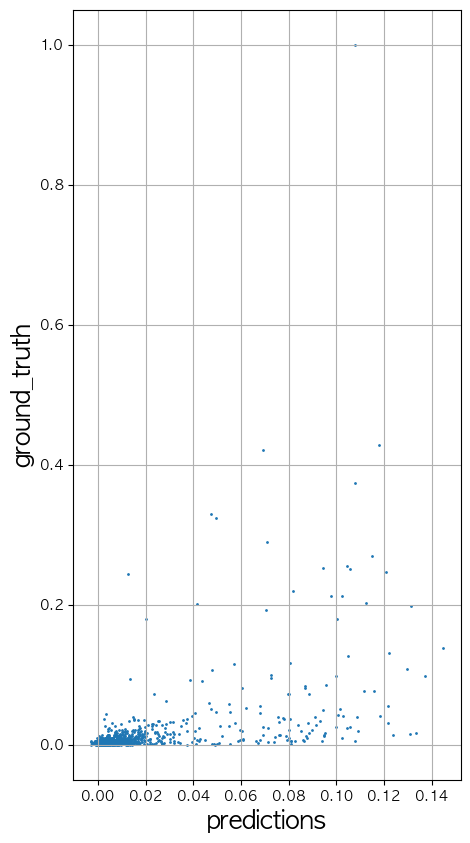

In [69]:
from matplotlib import pyplot as plt
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
plt.rcParams["figure.figsize"] = (5,10)
plt.rcParams['axes.grid'] = True



plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()


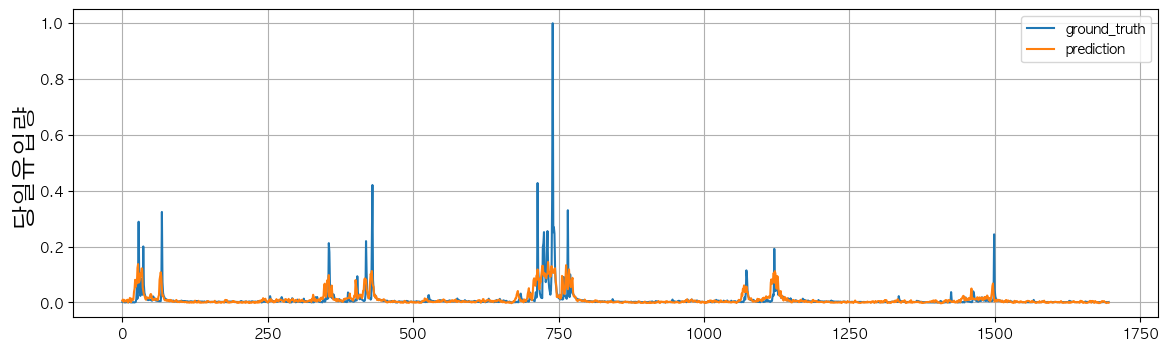

In [70]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel(y,fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()